# The transient Universe

### 1)
Read in `solutions/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

data = [time, flux, uncertainties] 

In [1]:
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 12

In [2]:
data =  np.load('../solutions/transient.npy')
time = data[:,0]
flux = data[:,1]
uncertainties = data[:,2]

Text(0, 0.5, 'flux')

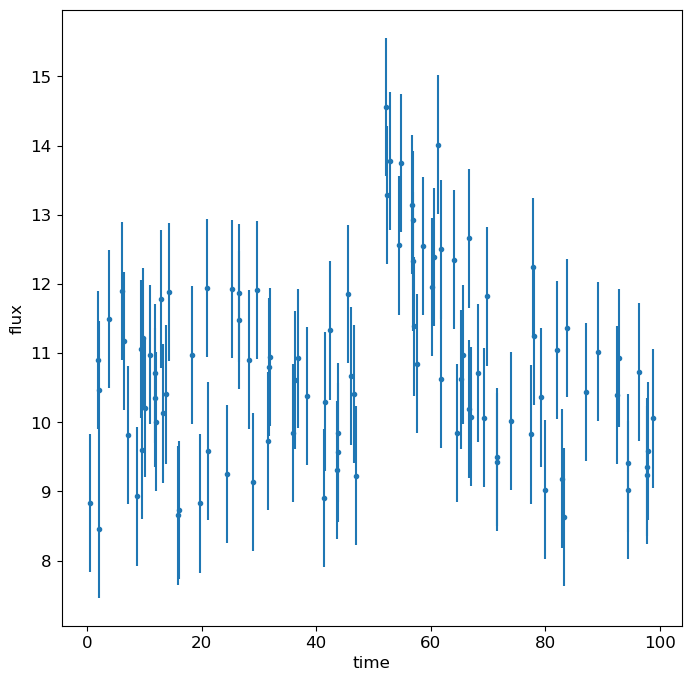

In [3]:
plt.errorbar(time, flux, yerr=uncertainties, fmt=".")
plt.xlabel("time")
plt.ylabel("flux")

### 2) 
One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.*

In [4]:
#Initial parameters
A_in = 5
b_in = 10
t0_in =50
alpha_in = 0.1

@np.vectorize
def model(t,A,b,t_0,alpha):
    t
    if t< t_0:
        return float(b)
    else:
        return float(b+A*np.exp(-alpha*(t-t_0)))

In [5]:
#@np.vectorize
def Initialmodel(theta,t):
    A,b,t_0,alpha = theta
    return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))

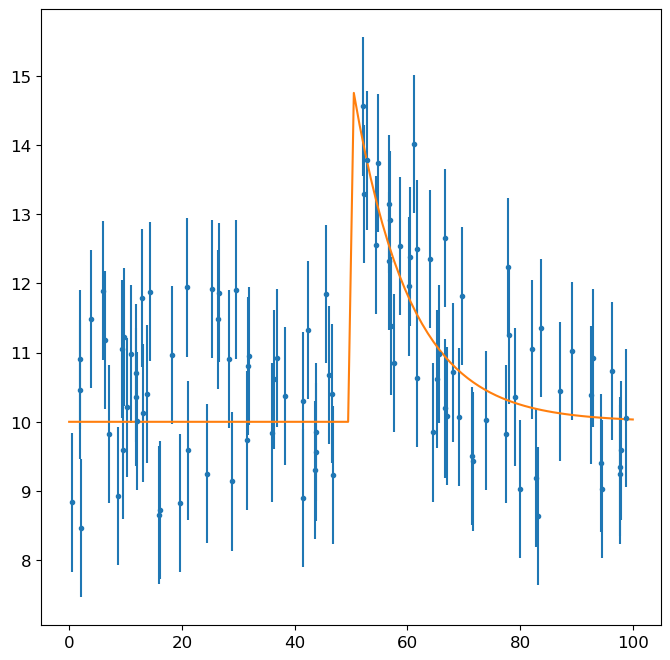

In [6]:

theta_in = np.array([A_in,b_in,t0_in,alpha_in])
xgrid = np.linspace(0,100,100)
ygrid = Initialmodel(theta_in,xgrid)

plt.errorbar(time, flux, yerr=uncertainties, fmt=".")
plt.plot(xgrid,ygrid)

plt.show()

---
This is how the teacher has define the function that described the model
> def model_prof(t,A,b,t_0,alpha):
     return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))

### 3)
Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$ (careful: uniform in $\ln\alpha$, not $\alpha$).

In [7]:
import emcee

In [8]:
A_min,A_max, = 0,50
b_min, b_max = 0,50
t0_min, t0_max = 0,100
alpha_min , alpha_max = np.exp(-5),np.exp(5)

In [9]:
#Define all the relevant functions

# y = flux, y_plot = y value from the plot,sigma = error of the data
def loglikelihood(theta,data, model = Initialmodel):
    #x = data[:,0]
    #y= data[:,1]
    #sigma = data[:,2]
    
    y_plot = model(theta,data[:,0])
    return -0.5 * np.sum(((data[:,1]-y_plot)**2)/(data[:,2]**2))
'''
def logprior(theta):
    A,b,t_0,alpha = theta 
    if A_min < A < A_max and b_min < b < b_max and t0_min < t_0 < t0_max and alpha_min < alpha < alpha_max:
        return np.log(np.log(alpha_max/alpha_min))
    else:
      return -np.inf
'''

def logprior(theta):
    A,b,t_0,alpha = theta 
    if A_min < A < A_max and b_min < b < b_max and t0_min < t_0 < t0_max and alpha_min < alpha < alpha_max:
        return 0.0 + 0.0 + 0.0 - np.log(alpha)
    else:
        return -np.inf

def logposterior(theta,data,model = Initialmodel):
    return loglikelihood(theta,data,model) + logprior(theta) 

In [10]:
ndim = 4 #number of parameter in the model
nwalkers = 20 #number of MCMC walkers
burn = 10000 #burn-in period to let chains stabilize
nsteps = 10000 #number of MCMC steps to take for each walker

starting_guesses = theta_in + 1e-1* np.random.randn(nwalkers, ndim)
print(starting_guesses.shape)

(20, 4)


In [11]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,logposterior,args = [data,Initialmodel])
sampler.run_mcmc(starting_guesses,nsteps)

C:\Users\utente\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


State([[ 6.06802308 10.53660772 49.15303872  0.18471507]
 [ 5.65884848 10.11243107 50.42797323  0.10745028]
 [ 2.93722659 10.4056538  50.23708284  0.07442703]
 [ 5.88351525 10.40141357 49.13545858  0.14797762]
 [ 4.21412719 10.1495224  51.77804522  0.12537792]
 [ 5.90456142 10.34366278 50.68755834  0.16517047]
 [ 5.56604483 10.23864602 48.77393648  0.10560283]
 [ 5.83885139 10.14620813 50.40425049  0.12048019]
 [ 3.50309786 10.23983958 51.15538833  0.08114334]
 [ 5.635037   10.41913987 48.06402636  0.12070722]
 [ 6.39757996 10.27237555 47.41325244  0.11428782]
 [ 5.36479475 10.3187511  48.50131936  0.09891303]
 [ 5.30007692 10.24960587 50.77997543  0.15744842]
 [ 5.55981493 10.30217397 48.35336003  0.09557466]
 [ 6.40130484 10.51563547 48.74170311  0.16591328]
 [ 3.70990591 10.2506993  52.04707053  0.12788722]
 [ 5.45904392 10.166797   50.24992307  0.11075908]
 [ 5.17525557 10.42513979 49.05574215  0.11961957]
 [ 3.98034524 10.23585426 49.67184658  0.08931157]
 [ 4.09730475 10.37473448

### 4) 
Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

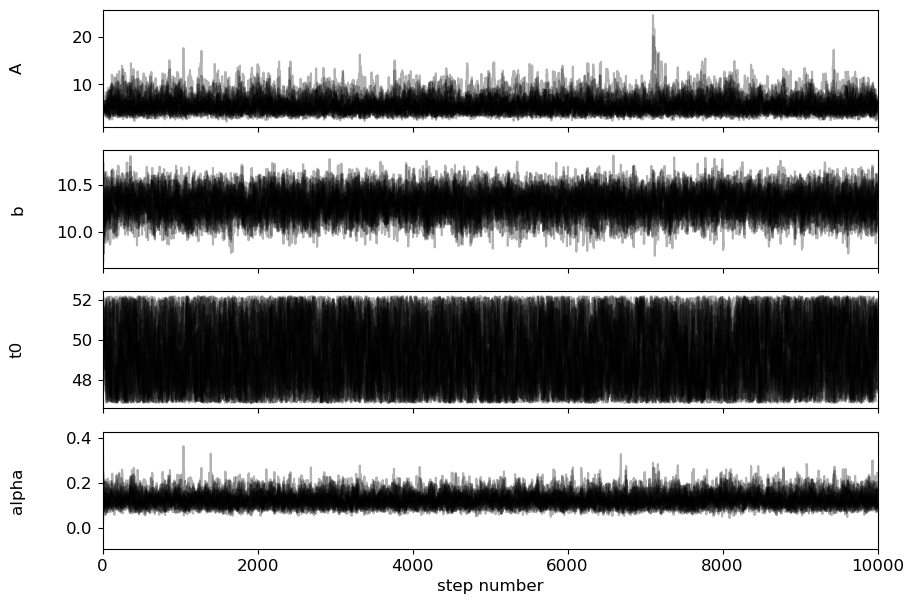

In [12]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["A","b","t0","alpha"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


### 5) 
Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.


In [13]:
tau = sampler.get_autocorr_time()
print(tau)

[72.23848016 56.76233368 70.93525464 61.98863859]


In [14]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(13200, 4)


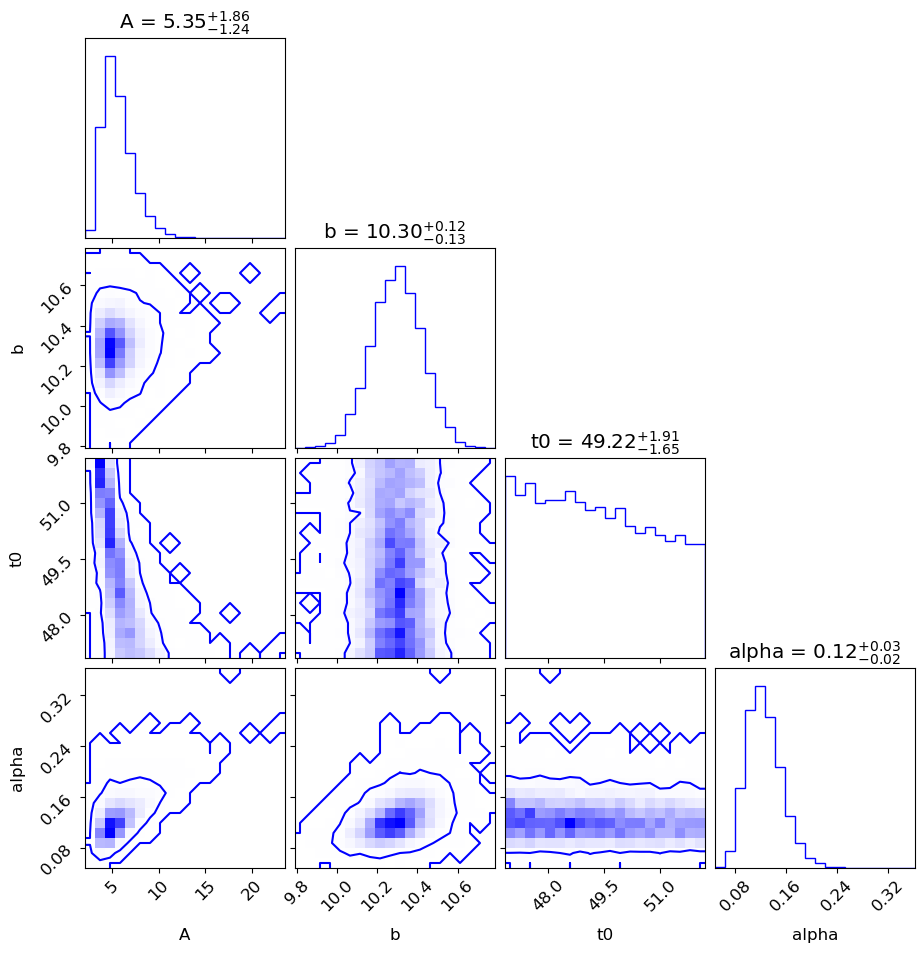

In [15]:
import corner
figure = corner.corner(samples,labels = labels, divergences=True, levels=[0,68,0.95], color='blue', plot_datapoints=False, show_titles=True)

#plt.savefig("CornerPlot_GW150914.pdf")
plt.show()

### 6)
Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

In [27]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(time, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(time, flux, yerr=uncertainties, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");


NameError: name 'tgrid' is not defined

### 7) 
For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance,  $t_0=X^{+Y}_{-Z}$ 

In [25]:
from IPython.display import display, Math

#A_median = np.percentile(A,)
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [90])
    print(mcmc)

[7.88410297]
[10.45658825]
[51.52172031]
[0.16194307]
